Spatiotemporal Analysis of Vegetation Health and Climate Variability in Somalia


In [2]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns

In [3]:
import ee
ee.Authenticate(auth_mode='notebook')  


True

NDVI data preprocessing 

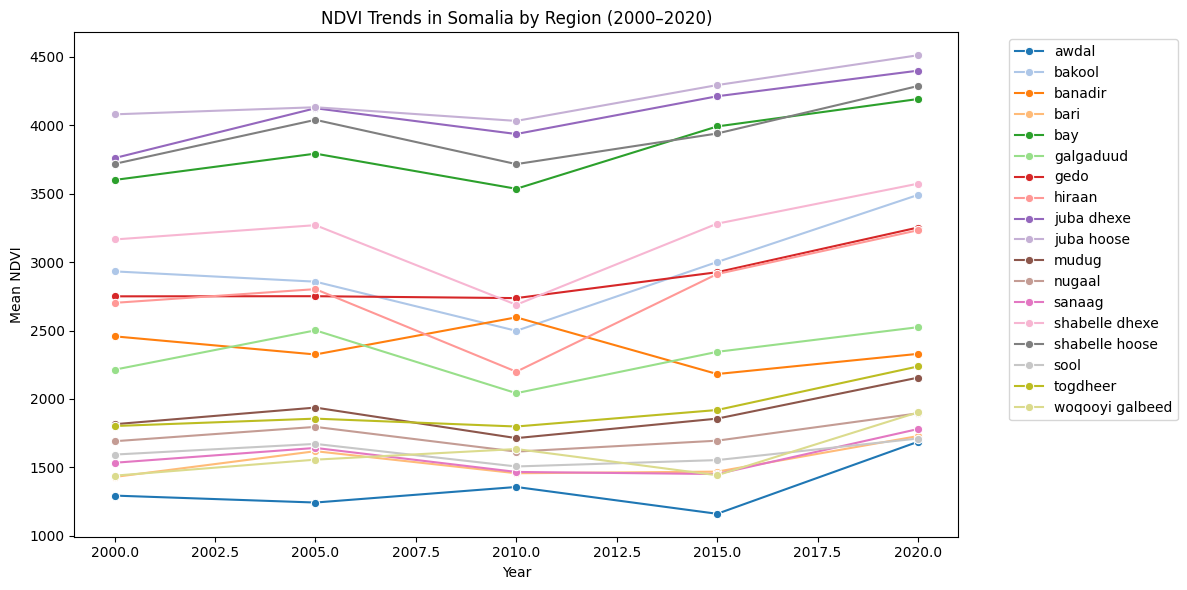

In [4]:
# loding the NDVI data and then combining it
years = [2000, 2005, 2010, 2015, 2020]
dfs = []
for year in years:
    df = pd.read_csv(f"Somalia_NDVI_{year}.csv")
    df["year"] = year
    df = df.rename(columns={"ADM1_NAME": "Region", "mean": "NDVI"})
    df = df[["Region", "NDVI", "year"]]
    dfs.append(df)

ndvi_df = pd.concat(dfs, ignore_index=True)

# fixing the region names
region_corrections = {
    "Bakol": "Bakool", "Nugal": "Nugaal",
    "Middle Juba": "Juba Dhexe", "Lower Juba": "Juba Hoose",
    "Middle Shebelle": "Shabelle Dhexe", "Lower Shebelle": "Shabelle Hoose"
}
ndvi_df["Region"] = ndvi_df["Region"].replace(region_corrections).str.strip().str.lower()

# NDVI trend summary
region_trends = ndvi_df.groupby(["Region", "year"])["NDVI"].mean().reset_index()

# plotting the trends
plt.figure(figsize=(12, 6))
sns.lineplot(data=region_trends, x="year", y="NDVI", hue="Region", marker="o", palette="tab20")
plt.title("NDVI Trends in Somalia by Region (2000–2020)")
plt.xlabel("Year")
plt.ylabel("Mean NDVI")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Mapping the NDVI data

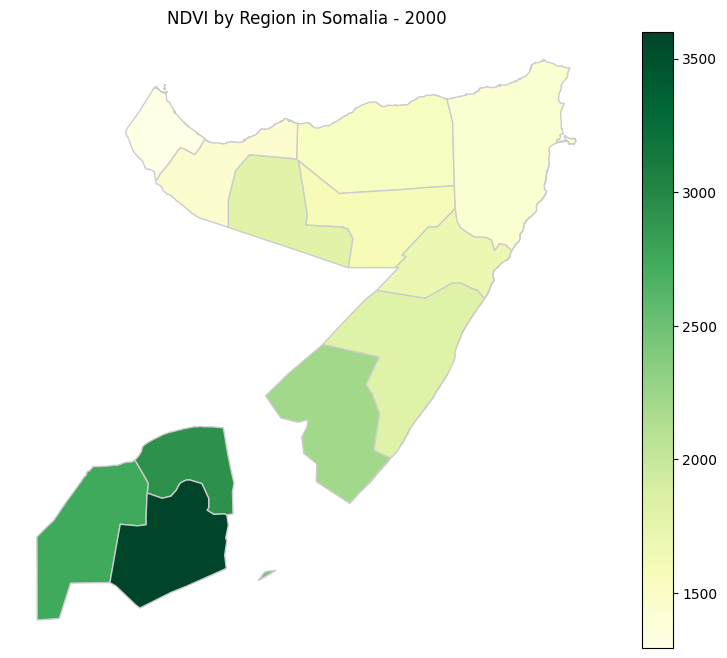

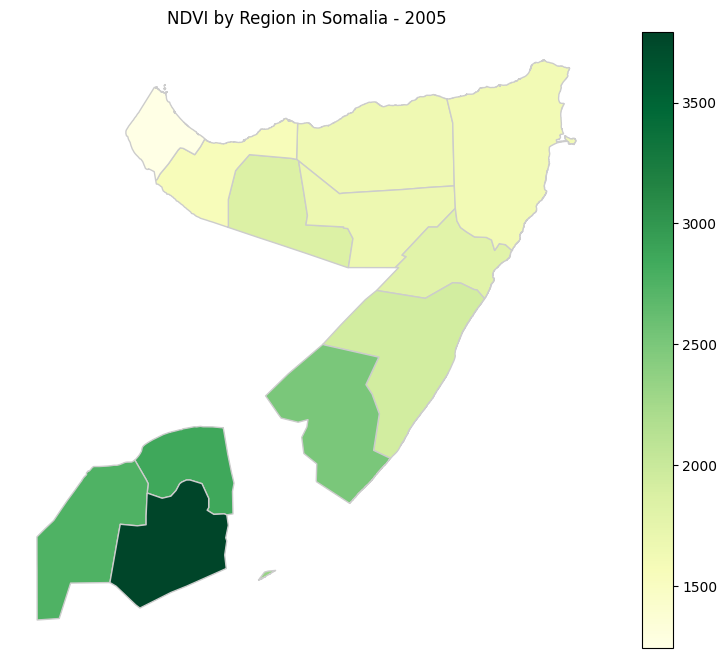

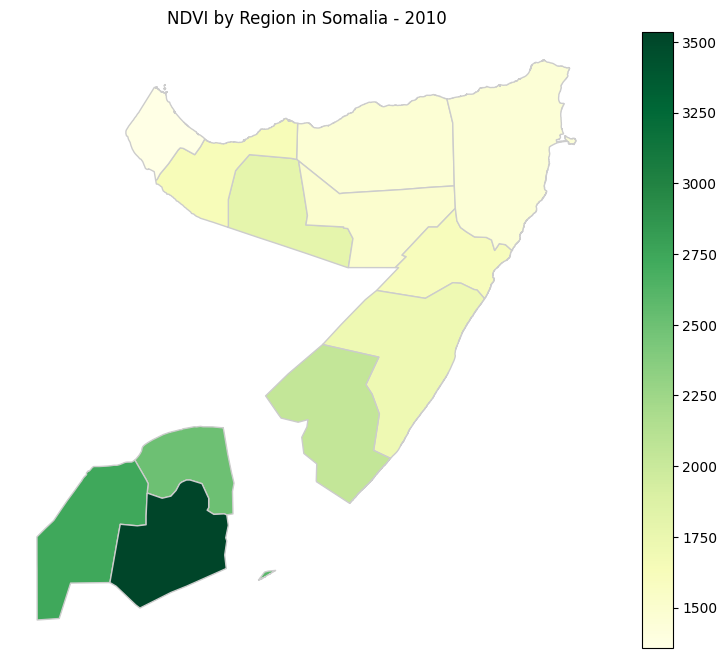

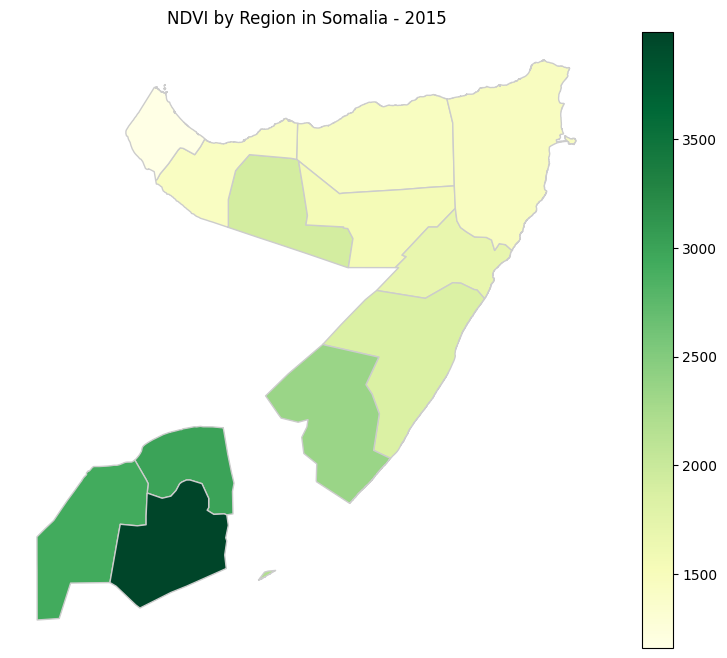

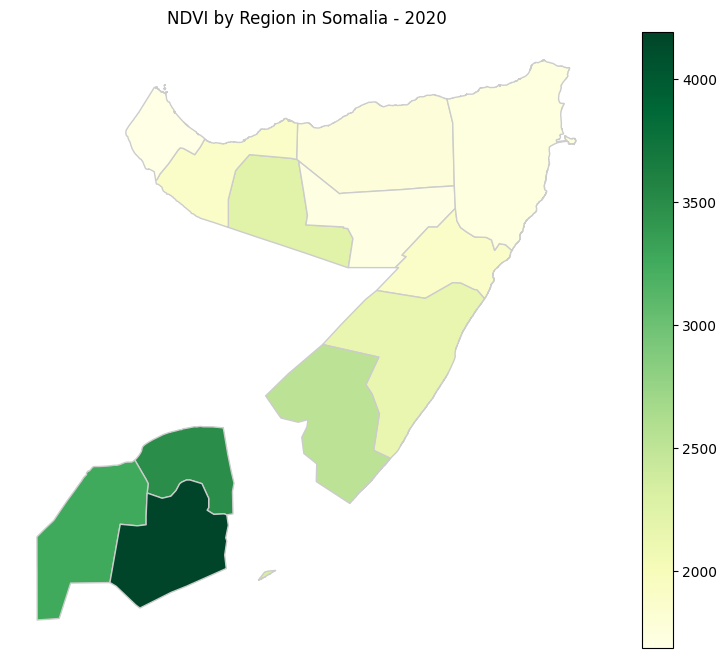

In [5]:
# loading the shapefile and standardize names
adm1_gdf = gpd.read_file("geoBoundaries-SOM-ADM1.shp")
adm1_gdf["shapeName"] = adm1_gdf["shapeName"].str.strip().str.lower()

def plot_ndvi_map(year):
    ndvi_year = ndvi_df[ndvi_df["year"] == year]
    merged = adm1_gdf.merge(ndvi_year, left_on="shapeName", right_on="Region")
    if merged.empty:
        print(f"No data for year {year}")
        return
    ax = merged.plot(column="NDVI", cmap="YlGn", legend=True, figsize=(10, 8), edgecolor="0.8")
    ax.set_title(f"NDVI by Region in Somalia - {year}")
    ax.axis("off")
    plt.show()

for yr in years:
    plot_ndvi_map(yr)

In [6]:
import ee, geemap
ee.Authenticate(auth_mode='notebook')
ee.Initialize()

In [7]:
import ee
import pandas as pd

# Authenticate and initialize EE 
ee.Authenticate(auth_mode='notebook')
ee.Initialize()

somalia_bounds = ee.Geometry.Polygon([
    [[41, -1], [51, -1], [51, 12], [41, 12], [41, -1]]
])

# loading the CHIRPS daily data
chirps = ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY") \
    .filterDate("2000-01-01", "2020-12-31") \
    .filterBounds(somalia_bounds)

#  annual rainfall image with renamed band
def annual_rainfall(year):
    start = ee.Date.fromYMD(year, 1, 1)
    end = start.advance(1, 'year')
    image = chirps.filterDate(start, end).sum().rename("precip")
    return image.set({'year': year, 'system:time_start': start.millis()})

years = list(range(2000, 2021))
annual_images = ee.ImageCollection([annual_rainfall(y) for y in years])

# reducing each image to a mean value over Somalia to return a feature to select 
rainfall_stats = annual_images.map(
    lambda img: ee.Feature(None, img.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=somalia_bounds,
        scale=5000,
        maxPixels=1e9
    )).set("year", img.get("year"))
)

# feature selection 
rainfall_list = rainfall_stats.aggregate_array("precip").getInfo()
years_list = rainfall_stats.aggregate_array("year").getInfo()

rainfall_df = pd.DataFrame({
    "year": years_list,
    "Rainfall": rainfall_list
}).sort_values("year")

print(rainfall_df.head())


   year    Rainfall
0  2000  287.653633
1  2001  257.641542
2  2002  310.999744
3  2003  274.687539
4  2004  287.043822


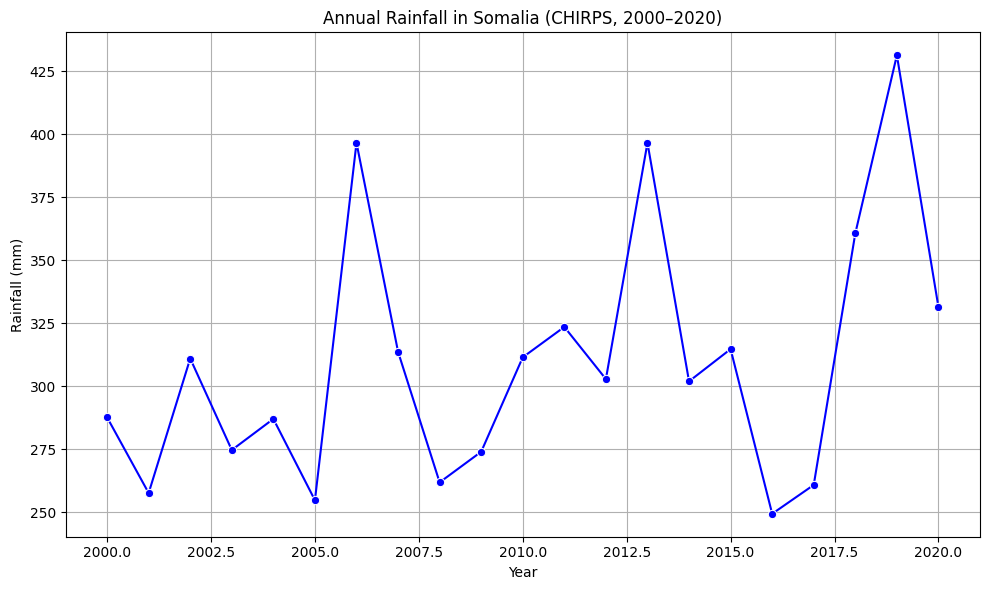

In [8]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=rainfall_df, x="year", y="Rainfall", marker="o", color="blue")
plt.title("Annual Rainfall in Somalia (CHIRPS, 2000–2020)")
plt.xlabel("Year")
plt.ylabel("Rainfall (mm)")
plt.grid(True)
plt.tight_layout()
plt.show()

CDD

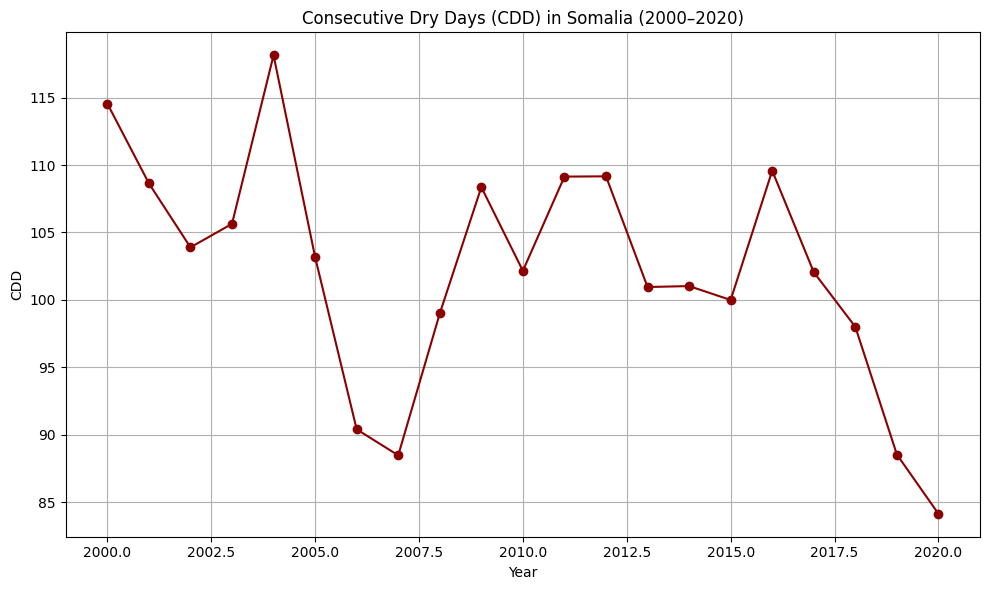

In [ ]:
climate_path = "era5-x0.25_timeseries_cdd,pr,tas_timeseries_annual_1950-2022_mean_historical_era5_x0.25_mean.xlsx"
xls = pd.ExcelFile(climate_path)

df_cdd = xls.parse("cdd")

df_cdd_long = df_cdd.melt(id_vars=["code", "name"], var_name="year_raw", value_name="CDD")

df_cdd_long["year"] = df_cdd_long["year_raw"].str.extract(r"(\d{4})").astype(int)
df_cdd_long = df_cdd_long[df_cdd_long["name"] == "Somalia"]
df_cdd_long = df_cdd_long[(df_cdd_long["year"] >= 2000) & (df_cdd_long["year"] <= 2020)]

plt.figure(figsize=(10, 6))
plt.plot(df_cdd_long["year"], df_cdd_long["CDD"], marker="o", color="darkred")
plt.title("Consecutive Dry Days (CDD) in Somalia (2000–2020)")
plt.xlabel("Year")
plt.ylabel("CDD")
plt.grid(True)
plt.tight_layout()
plt.show()

joining data

In [ ]:
cdd_df = df_cdd_long[["year", "CDD"]].copy()
ndvi_avg = ndvi_df.groupby("year")["NDVI"].mean().reset_index()

climate_df = ndvi_avg.merge(rainfall_df, on="year").merge(cdd_df, on="year")

print(climate_df.head())


   year         NDVI    Rainfall     CDD
0  2000  2443.103217  287.653633  114.55
1  2005  2550.655208  254.781079  103.18
2  2010  2362.596712  311.483143  102.16
3  2015  2534.851326  314.738042  100.00
4  2020  2826.922961  331.416902   84.16


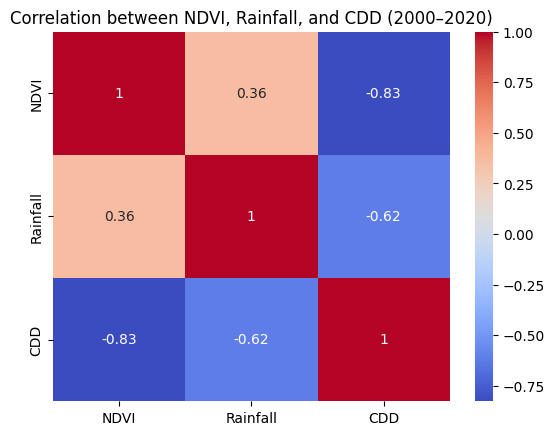

In [ ]:
sns.heatmap(climate_df[["NDVI", "Rainfall", "CDD"]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation between NDVI, Rainfall, and CDD (2000–2020)")
plt.show()

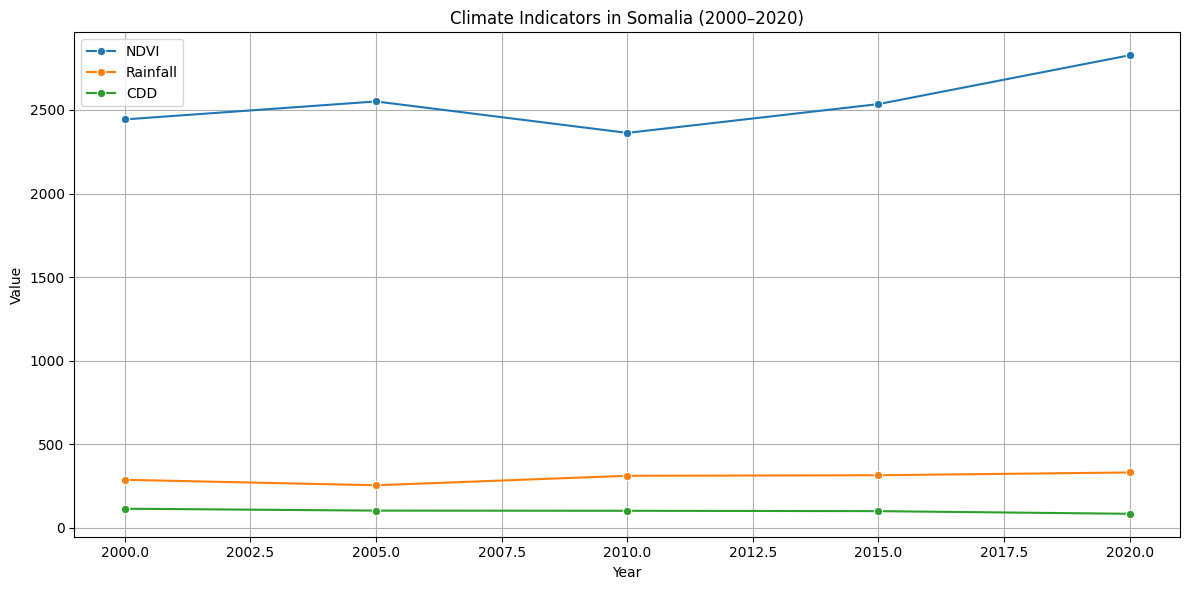

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=climate_df, x="year", y="NDVI", label="NDVI", marker="o")
sns.lineplot(data=climate_df, x="year", y="Rainfall", label="Rainfall", marker="o")
sns.lineplot(data=climate_df, x="year", y="CDD", label="CDD", marker="o")
plt.title("Climate Indicators in Somalia (2000–2020)")
plt.xlabel("Year")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


These results suggest that consecutive dry days (CDD) may be a more sensitive indicator of vegetation stress than total annual rainfall in Somalia. While rainfall does help, it's the distribution of rainfall (less clustering of dry days) that plays a larger role in supporting vegetation health, as shown by the strong NDVI-CDD inverse relationship.